In [1]:
import scanpy as sc
import os
import anndata as ad
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, norm
 
sc.settings.verbosity=0 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.n_jobs=4
sc.settings.set_figure_params(dpi=100, facecolor="white", frameon=False, figsize=(4,4))
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

%matplotlib inline



In [2]:
sc.settings.figdir = "fig5"


# Load

In [3]:
adata=sc.read_h5ad('/nfs/team298/ls34/disease_atlas/final_fb_adatas/adata_all_6150_umap5.h5ad.paga2.annotated9.lesionalonly')


# Plot counts

In [4]:

# Provided dictionary
categories = {
    'Fibrotic/scarring': [ 'Non-keloid scar',
 'Keloid scar',     "Dupuytren's",  'Systemic sclerosis',   'Morphoea (pansclerotic)',  #'Eosinophilic fasciitis',
                                            ],
        'Cancer': [ 'Acral melanoma',
 'Cutaneous melanoma',
 'Basal cell carcinoma', 
 'Squamous cell carcinoma',], # 'CTCL'
    'Inflammatory + high scarring risk': ['Acne', 'Hidradenitis supparativa',
                                             'Lupus (DLE)',
                                     'Sarcoidosis', 'Granuloma annulare'],
                                          
    'Inflammatory + low scarring risk': ['Psoriasis', 'Prurigo nodularis', 'Alopecia areata', 'Erythema migrans', 'Eczema',  'Drug reaction: lichenoid',
 'Drug reaction: DRESS','Lupus (SCLE)',],# ,

   # 'Benign neoplasia': ['Neurofibroma']
}
list(categories.keys())


['Fibrotic/scarring',
 'Cancer',
 'Inflammatory + high scarring risk',
 'Inflammatory + low scarring risk']

In [5]:
"""
original
custom_order=['Scarring',
 'Cancer',
 'Granulomatous inflammation',
 'Inflammatory + scarring risk',
 'Other inflammatory',
 'Benign\nneoplasia']

 
"""
custom_order=[  'Inflammatory+\nlow scarring risk',
 #'Granulomatous inflammation',
  'Inflammatory+\nhigh scarring risk',
              'Cancer',
 'Fibrotic/scarring',
 #'Benign\nneoplasia'
             ]

 

In [6]:
{x:x for x in adata.obs['disease_category'].unique()}



{'Inflammatory+\nlow scarring risk': 'Inflammatory+\nlow scarring risk',
 'Inflammatory+\nhigh scarring risk': 'Inflammatory+\nhigh scarring risk',
 'Fibrotic/scarring': 'Fibrotic/scarring',
 'Cancer': 'Cancer',
 'Benign neoplasia': 'Benign neoplasia'}

In [7]:
F1_NAME = "F1: Su"
F6_NAME = "F6: Inflammatory my"

In [8]:
for x in list(adata.obs['disease_category'].unique()):
    if x not in custom_order:
        print(x)

Benign neoplasia


In [9]:
set_categories = list(adata.obs['disease_category'].unique())
for x in custom_order:
    if x not in set_categories:
        print(x)

/home/jovyan/my-conda-envs/sko_ls/lib/python3.10/site-packages/pandas/core/arrays/categorical.py:595: RuntimeWarning: invalid value encountered in cast
  np.array(self.categories._na_value).astype(dtype)
/tmp/ipykernel_19149/3693816378.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(x='disease_category', y=is_F, data=donor_proportion_data, order=custom_order,
/tmp/ipykernel_19149/3693816378.py:22: UserWarning: 
The palette list has fewer values (1) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.swarmplot(x='disease_category', y=is_F, data=donor_proportion_data, order=custom_order,
/home/jovyan/my-conda-envs/sko_ls/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 7.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.

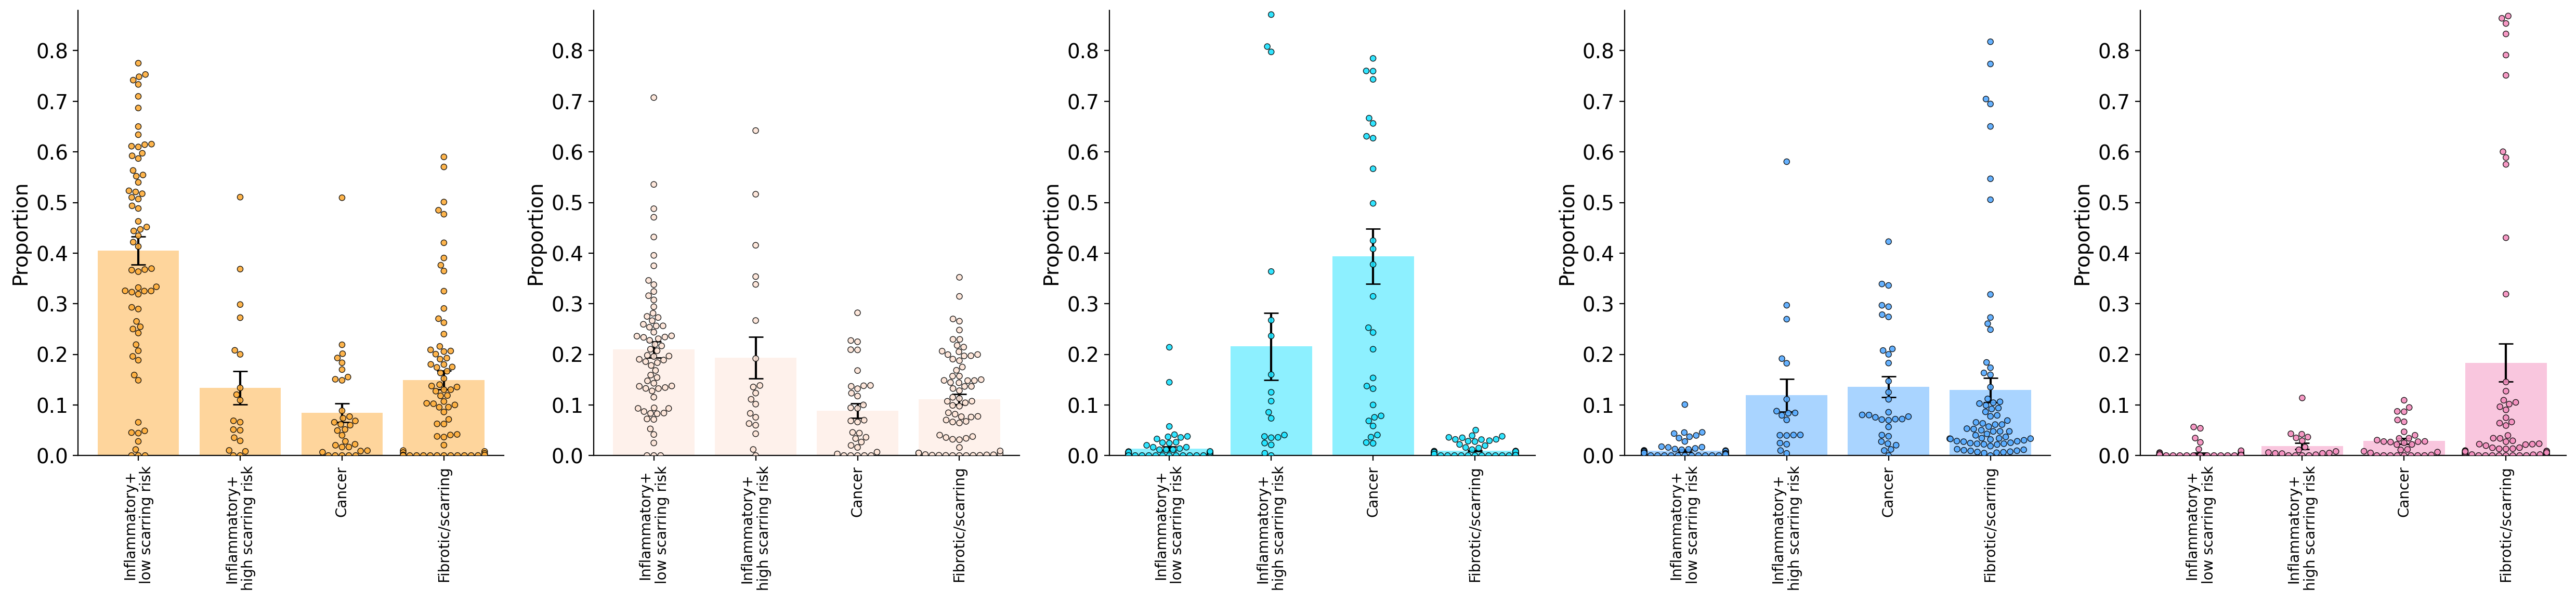

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Prepare the figure and axes for 5 plots in a single row
fig, axes = plt.subplots(1, 5, figsize=(25, 6))  # 1 row, 5 columns

# Define a function to create each plot with swarm and filled bar
def create_swarm_bar_plot_filled(ax, is_F, color, custom_order):
    # Calculate proportions of 'is_F' per DonorID
    donor_proportion_data = adata.obs.groupby(['DonorID', 'disease_category'], observed=True)[is_F].mean().reset_index()

    # Calculate the mean and SEM for each disease category
    proportion_data_mean = donor_proportion_data.groupby('disease_category', observed=True)[is_F].mean().reindex(custom_order)
    proportion_data_std = donor_proportion_data.groupby('disease_category', observed=True)[is_F].std().reindex(custom_order)
    proportion_data_n = donor_proportion_data.groupby('disease_category', observed=True)['DonorID'].count().reindex(custom_order)

    # Calculate SEM = SD / sqrt(n)
    proportion_data_sem = proportion_data_std / np.sqrt(proportion_data_n)

    # Plot the swarm plot for individual donor proportions
    sns.swarmplot(x='disease_category', y=is_F, data=donor_proportion_data, order=custom_order, 
                  ax=ax, size=4, palette=[color], edgecolor='black', linewidth=0.5, alpha=0.9)  # Set smaller size, black edge

    # Plot the bar plot with error bars (mean ± SEM), with filled bars and reduced alpha for visibility of dots
    ax.bar(x=proportion_data_mean.index, height=proportion_data_mean.values, 
           yerr=proportion_data_sem.values, color=color, alpha=0.5, capsize=5, linewidth=2)

    # Set y-axis limits to 0-0.88
    ax.set_ylim(0, 0.88)  # Set the y-axis limits here

    # Set plot aesthetics
    ax.set_ylabel('Proportion', fontsize=14)
    ax.set_xlabel('')  # Remove x-axis label
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(False)
    ax.tick_params(axis='x', labelrotation=90, labelsize=10)  # Set rotation and label size

# Define the data for each plot
adata.obs['is_F1'] = adata.obs['test13'].str.startswith(F1_NAME)
adata.obs['is_F6'] = adata.obs['test13'] == "F6: Myofibroblast"
adata.obs['is_F6_chemokine'] = adata.obs['test13'].str.startswith(F6_NAME)
adata.obs['is_F3'] = adata.obs['test12'].str.startswith("F3")
adata.obs['is_F7'] = adata.obs['test12'].str.startswith("F7")

# Define the colors for each plot
# Define the colors for each plot
colors = [
    [0.99607843, 0.67670896, 0.22857363, 1.0],  # Color for F1
        '#fee5d8',  # Color for F3

    '#1ce3ff',  # Color for F6 chemokine-high
        '#55aaff',  # Color for F6

    '#f48ebe'   # Color for F7
]

# Define the categories and is_F variables to plot
categories = ['is_F1', 'is_F3', 'is_F6_chemokine','is_F6',  'is_F7']
# Plot each category
for i, (category, color) in enumerate(zip(categories, colors)):
    create_swarm_bar_plot_filled(axes[i], category, color, custom_order)

plt.tight_layout()
plt.show()

In [11]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sc.settings.set_figure_params(dpi=600, facecolor="white", frameon=False, figsize=(4,8))


# Prepare the figure and axes for 4 plots in a single row
fig, axes = plt.subplots(1, 5, figsize=(20, 5), dpi=800)

# Define a function to create each plot with horizontal swarm and filled bar, and add significance stars
def create_horizontal_swarm_bar_plot_with_stars(ax, is_F, color, custom_order):
    # Calculate proportions of 'is_F' per DonorID
    donor_proportion_data = adata.obs.groupby(['DonorID', 'disease_category'], observed=True)[is_F].mean().reset_index()

    # Calculate the mean and SEM for each disease category
    proportion_data_mean = donor_proportion_data.groupby('disease_category', observed=True)[is_F].mean().reindex(custom_order)
    proportion_data_std = donor_proportion_data.groupby('disease_category', observed=True)[is_F].std().reindex(custom_order)
    proportion_data_n = donor_proportion_data.groupby('disease_category', observed=True)['DonorID'].count().reindex(custom_order)
    proportion_data_sem = proportion_data_std / np.sqrt(proportion_data_n)

    # Plot the swarm plot for individual donor proportions
    sns.swarmplot(y='disease_category', x=is_F, data=donor_proportion_data, order=custom_order, 
                  ax=ax, size=4, palette=[color], edgecolor='black', linewidth=0.5, alpha=0.9)

    # Plot the bar plot with error bars (mean ± SEM)
    ax.barh(y=proportion_data_mean.index, width=proportion_data_mean.values, 
            xerr=proportion_data_sem.values, color=color, alpha=0.5, capsize=5, linewidth=1,
               #linewidth=1, 
        edgecolor="black"  # Set edge color to light grey
           )

    # Set x-axis limits and specific x-ticks
    ax.set_xlim(0, 0.8)
    ax.set_xticks([0.25, 0.5])

    # Set plot aesthetics
    ax.set_xlabel('Proportion', fontsize=18)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(False)
    ax.tick_params(axis='y', labelsize=18)
    ax.set_ylabel('')  # Remove ylabel

# Define categories and colors to plot
categories = ['is_F3', 'is_F1', 'is_F6_chemokine', 'is_F6', 'is_F7']
colors = ['#fee5d8' ,
       [1.        , 1.        , 0.89803922, 1.        ],             #     [0.99607843, 0.67670896, 0.22857363, 1.0],  # Color for F1 
    '#1ce3ff',  # Color for F6 chemokine-high
    '#55aaff',  # Color for F6
    '#f48ebe'   # Color for F7
]

# Plot each category with significance stars in a single row
for i, (category, color) in enumerate(zip(categories, colors)):
    create_horizontal_swarm_bar_plot_with_stars(axes[i], category, color, custom_order)
    
    # Remove y-axis labels and ticks for all but the first plot
    if i > 0:
        axes[i].set_yticklabels([])

plt.tight_layout()
plt.savefig("fig4/by_disease_cat.pdf")
plt.show()
#sc.settings.set_figure_params(dpi=100, facecolor="white", frameon=False, figsize=(4,4))

    

/home/jovyan/my-conda-envs/sko_ls/lib/python3.10/site-packages/pandas/core/arrays/categorical.py:595: RuntimeWarning: invalid value encountered in cast
  np.array(self.categories._na_value).astype(dtype)
/tmp/ipykernel_19149/1863523674.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(y='disease_category', x=is_F, data=donor_proportion_data, order=custom_order,
/tmp/ipykernel_19149/1863523674.py:22: UserWarning: 
The palette list has fewer values (1) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.swarmplot(y='disease_category', x=is_F, data=donor_proportion_data, order=custom_order,
/home/jovyan/my-conda-envs/sko_ls/lib/python3.10/site-packages/pandas/core/arrays/categorical.py:595: RuntimeWarning: invalid value encountered in cast
  np.array(self.categories._na_value).astype(dtype)
/tmp/ipykernel_1